In [1]:
import utils as ul
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
cdir = ""
run = 129
pltdir = "Run" + str(run) + "/"

In [2]:
data = pd.read_csv(cdir+"Run{}_coinc.dat".format(run), sep="\t", header=None, low_memory=False)
data.columns = ["A", "B", "TimeL", "ChargeL", "ChannelIDL", "C", "D", "TimeR", "ChargeR", "ChannelIDR"]
data["Right"] = data.ChannelIDL % 128
data["Left"] = data.ChannelIDR % 128
data.ChannelIDL = data.Left
data.ChannelIDR = data.Right
a = [ul.toGeo(i) for i in data.Left]
b = [ul.toGeo(i) for i in data.Right]
data["GeoChannelIDL"] = a
data["GeoChannelIDR"] = b

In [3]:
data

,A,B,TimeL,ChargeL,ChannelIDL,C,D,TimeR,ChargeR,ChannelIDR,Right,Left,GeoChannelIDL,GeoChannelIDR
0,7,0,2520979457893,25.248905,124,14,0,2520979459138,14.670898,14,14,124,80,48
1,11,0,2521581667786,25.883739,84,13,0,2521581666991,21.879940,61,61,84,110,45
2,3,0,2521634622024,5.756729,84,8,0,2521634620970,12.905094,63,63,84,110,39
3,7,0,2522172610747,25.991615,19,9,0,2522172610403,16.141689,110,110,19,17,112
4,7,0,2522891089003,13.011932,71,2,0,2522891089034,10.264580,76,76,71,71,93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2683178,7,0,1802518743854063,18.145618,0,8,0,1802518743853065,24.037140,113,113,0,32,96
2683179,6,0,1802518991429427,12.290607,83,6,0,1802518991428656,23.236633,47,47,83,127,22
2683180,6,0,1802519499174975,19.120255,82,11,0,1802519499174532,19.889511,3,3,82,111,40
2683181,7,0,1802520209659963,24.748562,99,1,0,1802520209663859,0.468582,119,119,99,99,72


In [64]:
# dimensions
# let D be the distance between the left and right PCBs (assuming diametrically opposite from origin and at same z-height)
# let unit be the pixel pitch of about 25.8 mm / 8
# let x be pointing inwards (towards the closed wall of the darkbox)
# let y be pointing towards the right PCB
# let z be pointing up

# D = 160 #160mm for now
# unit = 25.8/8

# def xyzt(data):
#     cidL = np.array(data["GeoChannelIDL"])
#     cidR = np.array(data["GeoChannelIDR"])
#     xi = cidL%8
#     zi = (cidL/8).astype(int)
#     yL = np.array([-D/2]*len(cidL))
#     xL = unit*(xi-3.5)
#     zL = unit*(8-zi)

#     xi = cidR%8
#     zi = (cidR/8).astype(int)
#     yR = np.array([D/2]*len(cidR))
#     xR = unit*(3.5-xi)
#     zR = unit*(8-zi)
    
#     tL = np.array(data["TimeL"])
#     tR = np.array(data["TimeR"])
#     return np.transpose([xL,yL,zL,tL,xR,yR,zR,tR])

def leftX(i):
    if i < 64:
        z = -182.5/2
        y = 0.5 + 1.5 + 3*(7 - (i // 8))
        x = -(-1.5 + 3*((i % 8) - 3))
    if i >= 64:
        z = -182.5/2
        y = -0.5 - 1.5 + 3*(8 - (i // 8))
        x = -(-1.5 + 3*((i % 8) - 3))
    return [x,y,z]
def rightX(i):
    if i < 64:
        z = 182.5/2
        y = 0.5 + 1.5 + 3*(7 - (i // 8))
        x = (-1.5 + 3*((i % 8) - 3))
    if i >= 64:
        z = 182.5/2
        y = -0.5 - 1.5 + 3*(8 - (i // 8))
        x = (-1.5 + 3*((i % 8) - 3))
    return [x,y,z]

In [68]:
#PCB 6
nEvents = len(data["GeoChannelIDL"])
p = np.zeros(shape=(8,nEvents))
left = np.array(data["GeoChannelIDL"])
right = np.array(data["GeoChannelIDR"])
leftT = data["TimeL"]
rightT = data["TimeR"]
for u in tqdm(range(nEvents)):
    i = left[u]
    p[0:3,u] = leftX(i)

    #PCB 5
    i = right[u]
    
    p[4:7,u] = rightX(i)
    
p[3,:] = leftT
#p[4,:] = data["ChargeL"]
p[7,:] = rightT
#p[9,:] = data["ChargeR"]

100%|█████████████████████████████████████████████████████████████████████| 2683183/2683183 [00:33<00:00, 80387.17it/s]


In [69]:
np.savetxt(pltdir+"pointdata_nocuts.txt",p)

In [2]:
p = np.loadtxt(pltdir+"pointdata_nocuts.txt")

In [70]:
np.savetxt(pltdir+"listdata_nocuts.csv",np.transpose(p), delimiter=',', fmt='%d')

In [71]:
dt = p[3]-p[7] #ps
dx = 0.3*dt #mm

center = np.array([(p[0,:]+p[4,:])/2, (p[1,:]+p[5,:])/2, (p[2,:]+p[6,:])/2])
line = np.array(((p[0,:]-p[4,:]), (p[1,:]-p[5,:]), (p[2,:]-p[6,:])))
line = dx*line/(np.linalg.norm(line))
point = center+line
#indices = left<64
#energy = p[4,:]+p[9,:]

In [72]:
#xyz = point[:,indices]
xyz = point[:,0:10000]
#E = energy[0:10000]*(0.02*16)

[[ 10.5  -10.5  -10.5   10.5   10.5   10.5  -10.5  -10.5   10.5   10.5 ]
 [ 23.    23.     2.     2.    23.    -2.    -2.   -23.   -23.    -2.  ]
 [-91.25 -91.25 -91.25 -91.25 -91.25 -91.25 -91.25 -91.25 -91.25 -91.25]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 58.94it/s]


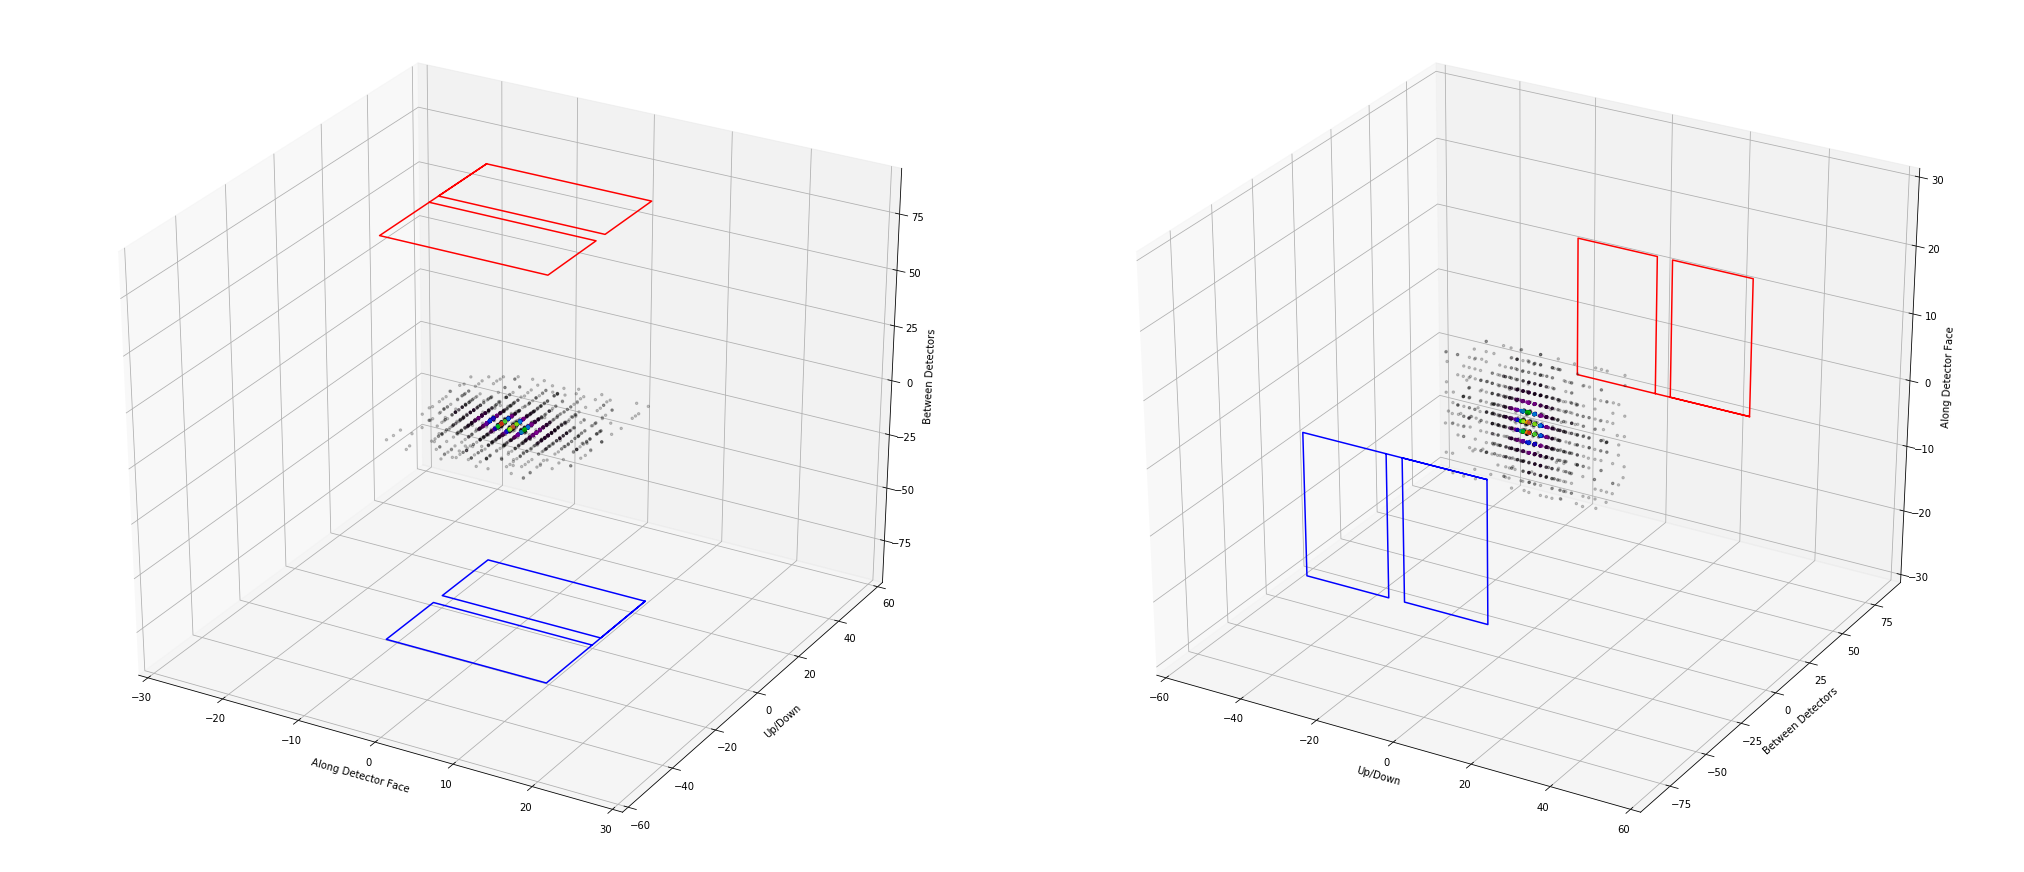

In [73]:
det = [0,7,63,63-7,0,64,64+7,127,120,64]
detpoint = np.transpose([leftX(i) for i in det])
detpoint2 = np.transpose([rightX(i) for i in det])
print(detpoint)

xy = np.vstack([xyz[0],xyz[2],xyz[1]])
z = gaussian_kde(xy)(xy)
#ax1.scatter(b, data["CTR"], c=z, s=16, cmap = "nipy_spectral")

# fig = plt.figure(figsize=(12,12))
# ax = fig.add_subplot(111, projection='3d')
lim = np.array([[-30,30],[-30*2,30*2],[-182.5/2,182.5/2]])
labels = ["Along Detector Face","Up/Down","Between Detectors"]

fig = plt.figure(figsize = (28,12),constrained_layout=True)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax = [ax1,ax2]
for i in tqdm(range(2)):
    ax[i].scatter(xyz[i%3],xyz[(i+1)%3],xyz[(i+2)%3], c=z,s=6,alpha = 0.2,cmap="nipy_spectral")
    ax[i].set_xlim(lim[i%3,0],lim[i%3,1])
    ax[i].set_ylim(lim[(i+1)%3,0],lim[(i+1)%3,1])
    ax[i].set_zlim(lim[(i+2)%3,0],lim[(i+2)%3,1])
    ax[i].set_xlabel(labels[i%3])
    ax[i].set_ylabel(labels[(i+1)%3])
    ax[i].set_zlabel(labels[(i+2)%3])
    #ax.scatter([0],[0],[0],c='r',s=6)
    #ax.scatter([0],[-180.25/2],[0],c='g',s=6)
    ax[i].plot(detpoint[i%3],detpoint[(i+1)%3],detpoint[(i+2)%3],c='b')
    ax[i].plot(detpoint2[i%3],detpoint2[(i+1)%3],detpoint2[(i+2)%3],c='r')
fig.savefig(pltdir+"Image_no_cuts.png")
plt.show()

In [74]:
#LOR = np.array([(p[0,:]-p[4,:]), (p[1,:]-p[5,:]), (p[2,:]-p[6,:])])

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1415.73it/s]


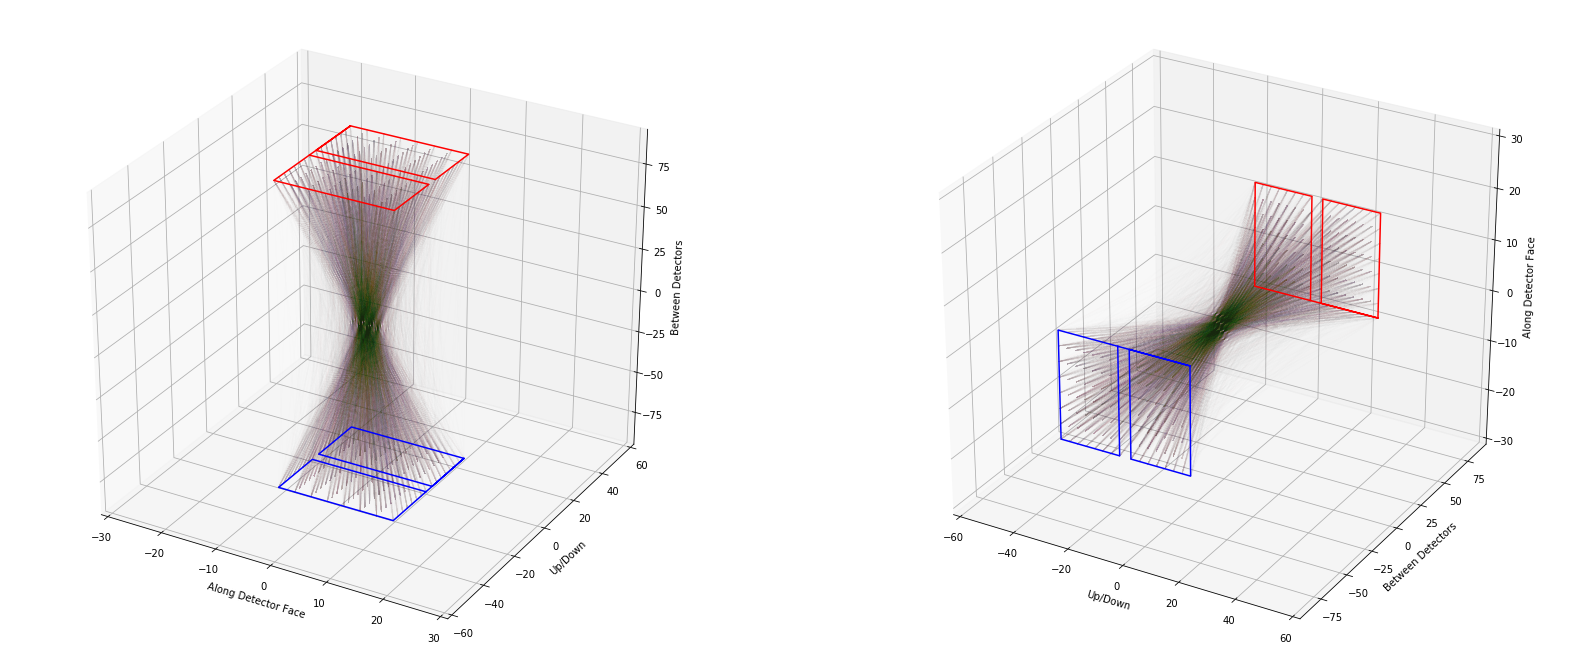

In [75]:
#Basic Backprojection

fig = plt.figure(figsize=(28,12))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax = [ax1,ax2]
nEvt = xyz.shape[1]
for i in range(2):
    #ax[i].scatter(xyz[i%3],xyz[(i+1)%3],xyz[(i+2)%3], c=z,s=16,alpha = 0.2,cmap="nipy_spectral")
    for j in tqdm(range(nEvt)):
        ax[i].plot(xs=[p[i%3,j], p[4+i%3,j]], ys=[p[(i+1)%3,j],p[4+(i+1)%3,j]],zs=[p[(i+2)%3,j],p[4+(i+2)%3,j]], alpha = 0.002)
    
    ax[i].set_xlim(lim[i%3,0],lim[i%3,1])
    ax[i].set_ylim(lim[(i+1)%3,0],lim[(i+1)%3,1])
    ax[i].set_zlim(lim[(i+2)%3,0],lim[(i+2)%3,1])
    ax[i].set_xlabel(labels[i%3])
    ax[i].set_ylabel(labels[(i+1)%3])
    ax[i].set_zlabel(labels[(i+2)%3])
    #ax.scatter([0],[0],[0],c='r',s=6)
    #ax.scatter([0],[-180.25/2],[0],c='g',s=6)
    ax[i].plot(detpoint[i%3],detpoint[(i+1)%3],detpoint[(i+2)%3],c='b')
    ax[i].plot(detpoint2[i%3],detpoint2[(i+1)%3],detpoint2[(i+2)%3],c='r')
fig.savefig(pltdir+"Image_test_nocuts.png")
plt.show()

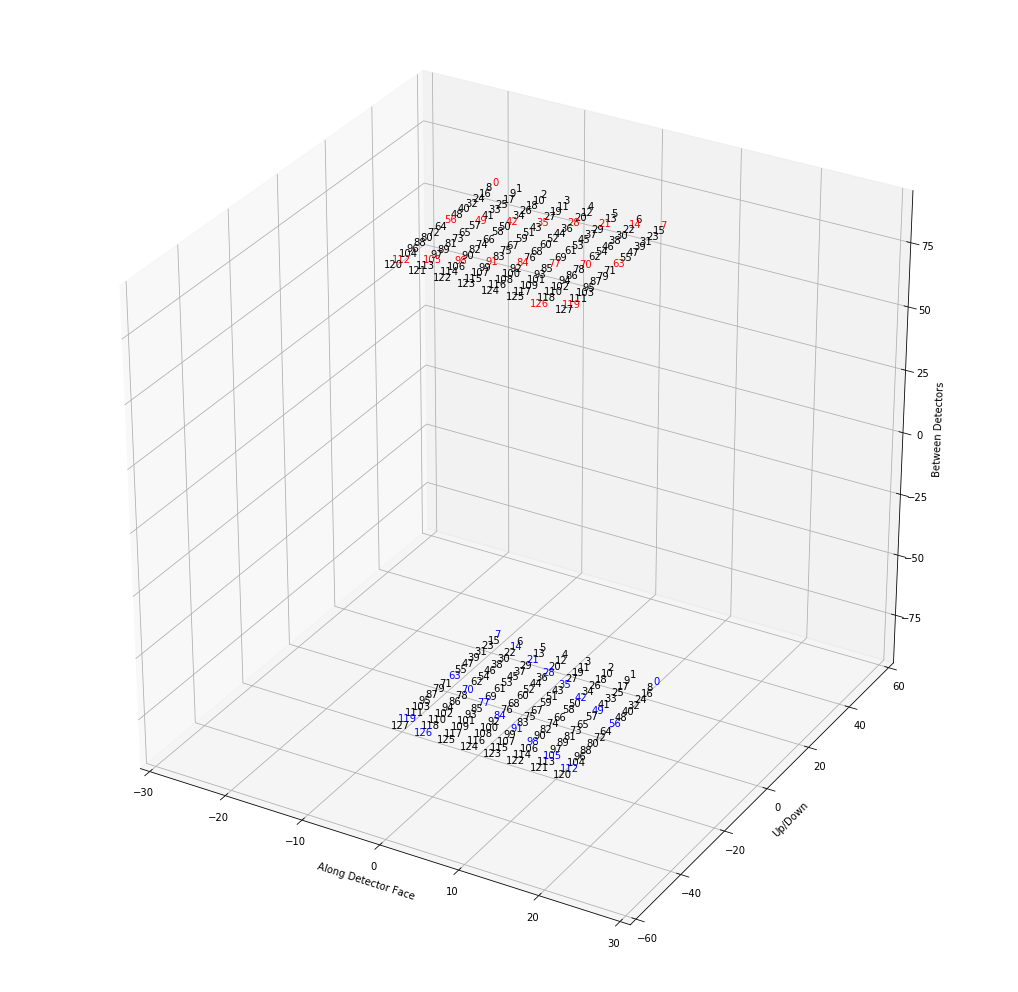

In [92]:
fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(111, projection='3d')    
for i in range(128):
    color='k'
    px = leftX(i)
    x,y,z = px
    if(i%7==0):
        color = 'b'
    ax.text(x,y,z,str(i),color=color)
    px = rightX(i)
    x,y,z = px
    if(i%7==0):
        color = 'r'
    ax.text(x,y,z,str(i),color=color)
ax.set_xlim(lim[0,0],lim[0,1])
ax.set_ylim(lim[1,0],lim[1,1])
ax.set_zlim(lim[2,0],lim[2,1])
ax.set_xlabel(labels[0])
ax.set_ylabel(labels[1])
ax.set_zlabel(labels[2])
plt.savefig(pltdir+"Convention.png")
plt.show()

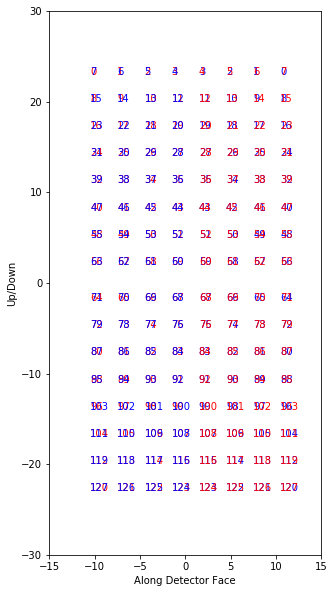

In [85]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in range(128):
    px = leftX(i)
    x,y,z = px
    ax.text(x,y,str(i),color='b')
    px = rightX(i)
    x,y,z = px
    ax.text(x,y,str(i),color='r')
ax.set_xlim(lim[0,0]/2,lim[0,1]/2)
ax.set_ylim(lim[1,0]/2,lim[1,1]/2)
ax.set_xlabel(labels[0])
ax.set_ylabel(labels[1])
ax.set_aspect(1)
plt.savefig(pltdir+"Convention2.png")
plt.show()